# Prepare Data

In [1]:
from btbot.database.utils import get_symbols, get_info_SP500

df_info = get_info_SP500()
symbols = df_info['Ticker symbol'].values

import quandl
from time import sleep
from tqdm import tqdm_notebook

QUANDL_APIKEY = "VBG5xmxqpRXRex_xQ-9Y"
quandl.ApiConfig.api_key = QUANDL_APIKEY

for symbol in tqdm_notebook(symbols):
    name = f'WIKI/{symbol}'
    try:
        df = quandl.get(name)
    except:
        continue
    path = f'../datasets/US_stocks/{symbol}.csv'
    df.to_csv(path)
    sleep(1)

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

dfs = []
for symbol in tqdm_notebook(symbols):
    path = f'../datasets/US_stocks/{symbol}.csv' 
    try:
        df = pd.read_csv(path)
        df_ = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
        df_.index = pd.DatetimeIndex(df['Date'])
        columns = [f'{symbol}_Open', f'{symbol}_High', f'{symbol}_Low', f'{symbol}_Close', f'{symbol}_Volume']
        df_.columns = columns
        dfs.append(df_)
    except:
        continue
stock_df = pd.concat(dfs, axis=1)

HBox(children=(IntProgress(value=0, max=505), HTML(value='')))

In [4]:
macro_symbols = ["FRED/DCOILWTICO", "WGC/GOLD_DAILY_USD", "FRED/DTWEXM",
           "USTREASURY/YIELD", "FRED/T10Y2Y"]

macro_dfs = []
for symbol in tqdm_notebook(macro_symbols):
    name = symbol.split('/')[1]
    path = f'../datasets/macro/{name}.csv'
    df = pd.read_csv(path)
    columns = df.columns[1:]
    df_ = df[columns]
    df_.columns = [f'{name}_{col}' for col in columns]
    df_.index = pd.DatetimeIndex(df["Date"])
    macro_dfs.append(df_)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

In [5]:
macro_df = pd.concat(macro_dfs, axis=1)
macro_df = macro_df.interpolate(method='linear').dropna()

In [6]:
macro_df.head()

,DCOILWTICO_Value,GOLD_DAILY_USD_Value,DTWEXM_Value,YIELD_1 MO,YIELD_3 MO,YIELD_6 MO,YIELD_1 YR,YIELD_2 YR,YIELD_3 YR,YIELD_5 YR,YIELD_7 YR,YIELD_10 YR,YIELD_20 YR,YIELD_30 YR,T10Y2Y_Value
Date,,,,,,,,,,,,,,,
2001-07-31,26.70,265.90,109.1778,3.67,3.54,3.47,3.53,3.79,4.06,4.57,4.86,5.07,5.61,5.51,1.28
2001-08-01,26.83,267.35,108.9578,3.65,3.53,3.47,3.56,3.83,4.09,4.62,4.90,5.11,5.63,5.53,1.28
2001-08-02,27.86,267.00,108.7832,3.65,3.53,3.46,3.57,3.89,4.17,4.69,4.97,5.17,5.68,5.57,1.28
2001-08-03,27.51,267.85,108.4799,3.63,3.52,3.47,3.57,3.91,4.22,4.72,4.99,5.20,5.70,5.59,1.29
2001-08-06,27.70,267.20,108.6446,3.62,3.52,3.47,3.56,3.88,4.17,4.71,4.99,5.19,5.70,5.59,1.31


In [31]:
start = '2000-01-01'
end = '2017-12-31'
features = macro_df.loc[(macro_df.index >= start) & (macro_df.index <= end)]
stock_df = stock_df.loc[(stock_df.index >= start) & (stock_df.index <= end)]

In [32]:
symbol = 'MSFT'
stock_features = stock_df[[f'{symbol}_Open', f'{symbol}_High', f'{symbol}_Low', f'{symbol}_Close', f'{symbol}_Volume']]
columns = ['Open', 'High', 'Low', 'Close', 'Volume']
stock_features.columns = columns
stock_features = stock_features.dropna()

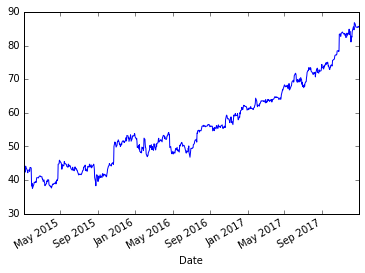

In [33]:
%matplotlib inline

stock_features['Close'].plot()

In [34]:
stock_features.dropna(inplace=True)
features.dropna(inplace=True)
time_idx = features.index & stock_features.index
stock_features = stock_features.loc[time_idx]
features = features.loc[time_idx]

/home/tom/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [35]:
print(stock_features.shape)
print(features.shape)

(754, 5)
(754, 15)


# Backtest

In [36]:
import backtrader as bt
import backtrader.indicators as btind

In [69]:
import xgboost as xgb

model_params = {'booster': 'dart',
         'max_depth': 5, 'learning_rate': 0.1,
         'objective': 'multi:softmax', 'num_class': 3,
         'sample_type': 'uniform',
         'rate_drop': 0.1,
         'skip_drop': 0.5,
         'silent': True}


def print_trade_analysis(analyzer):
    #Get the results we are interested in
    total_open = analyzer.total.open
    total_closed = analyzer.total.closed
    total_won = analyzer.won.total
    total_lost = analyzer.lost.total
    win_streak = analyzer.streak.won.longest
    lose_streak = analyzer.streak.lost.longest
    pnl_net = round(analyzer.pnl.net.total,2)
    strike_rate = (total_won / total_closed) * 100
    #Designate the rows
    h1 = ['Total Open', 'Total Closed', 'Total Won', 'Total Lost']
    h2 = ['Strike Rate','Win Streak', 'Losing Streak', 'PnL Net']
    r1 = [total_open, total_closed,total_won,total_lost]
    r2 = [strike_rate, win_streak, lose_streak, pnl_net]
    #Check which set of headers is the longest.
    if len(h1) > len(h2):
        header_length = len(h1)
    else:
        header_length = len(h2)
    #Print the rows
    print_list = [h1,r1,h2,r2]
    row_format ="{:<15}" * (header_length + 1)
    print("Trade Analysis Results:")
    for row in print_list:
        print(row_format.format('',*row))
    
    
    

class FirstStrategy(bt.Strategy):
    SELL = 0
    BUY = 1
    SIZE = 10
    params = (
        ('period', 21),
        ('num_round', 50),
        ('timelag', 10),
        ('num_data', 200),
        ('scale', 252),
        ('high_th', 5),
        ('low_th', -5)
    )
    
    def __init__(self):
        self.startcash = self.broker.getvalue()
        self.stock = self.getdatabyname('stock')
        self.rsi = btind.RSI_SMA(self.stock.close, period=self.p.period + self.p.num_data)
        self.scaler = StandardScaler()
        
    def next(self):
        X = []
        y = []
        require_size = self.p.timelag + self.p.num_data
        if len(self.stock.get(ago=0, size=require_size)) == 0:
            return None
        for i in range(self.p.num_data):
            features = []
            st_idx = -(i+1)
            close_lag = np.array(self.stock.close.get(ago=st_idx, size=self.p.timelag))
            features.append(close_lag / self.stock.close[st_idx])
            volume_lag = np.array(self.stock.volume.get(ago=st_idx, size=self.p.timelag))
            features.append(volume_lag / self.stock.volume[st_idx])
            X.append(np.hstack(features))
            an_ret = (self.stock.close[st_idx + 1] / self.stock.close[st_idx] - 1.) * self.p.scale
            y.append(self._label(an_ret))
        # Training
        X = self.scaler.fit_transform(np.array(X))
        y = np.array(y)
        dtrain = xgb.DMatrix(X, label=y)
        bst = xgb.train(model_params, dtrain, self.p.num_round)
        # Prediction
        features = []
        features.append(np.array(self.stock.close.get(size=self.p.timelag)) / self.stock.close[0])
        features.append(np.array(self.stock.volume.get(size=self.p.timelag)) / self.stock.volume[0])
        pred_X = self.scaler.transform(np.array([np.hstack(features)]))
        pred_X = xgb.DMatrix(pred_X)
        signal = bst.predict(pred_X)[0]
        pos = self.getpositionbyname('stock').size
        if signal == self.SELL:
            if pos >= 0:
                size = self.SIZE + abs(pos)
                print('SELL')
                self.sell(data=self.stock, size=size)
        elif signal == self.BUY:
            if pos <= 0:
                size = self.SIZE + abs(pos)
                print('BUY')
                self.buy(data=self.stock, size=size)
        
        
    def _label(self, y):
        if y < self.p.low_th:
            return self.SELL
        elif y > self.p.high_th:
            return self.BUY
        else:
            return 2
                
    def stop(self):
        trade_analyzer = self.analyzers.getbyname('trade').get_analysis()
        print_trade_analysis(trade_analyzer)
        

In [70]:
%%time

from btbot.cerebro import Cerebro

class MacroData(bt.feeds.PandasData):
    linesoverride = True
    lines = ('dollar', 'gold', 'macro', 'yield')  # Replace hierarchy with this one
    params = (('dollar', 0),
              ('gold', 1),
              ('macro', 2),
              ('yield', 3))

stock = bt.feeds.PandasData(dataname=stock_features, close=0, volume=1)
macro = MacroData(dataname=features, close=0, volume=1)

cerebro = Cerebro()
startcash = 100000
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade')
cerebro.adddata(stock, name='stock')
#  cerebro.adddata(macro, name='macro')
cerebro.addstrategy(FirstStrategy)
cerebro.broker.setcash(startcash)
strategy = cerebro.run()[0]

BUY
SELL
BUY
SELL
BUY
Trade Analysis Results:
               Total Open     Total Closed   Total Won      Total Lost     
               1              4              3              3              
               Strike Rate    Win Streak     Losing Streak  PnL Net        
               75.0           3              3              146.32         
CPU times: user 3min 20s, sys: 1.66 s, total: 3min 22s
Wall time: 26.4 s


In [66]:
cerebro.plot()

UnboundLocalError: local variable 'fig' referenced before assignment

In [68]:
analyzer = strategy.analyzers[0]

In [55]:
analyzer.

In [ ]:
strategy.analyzers.getbyname